# Udacity Project: Advance Lane Finding

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import visualize_helper as visual

## 1 - Camera calibration

### 1.1 - Import relevant libraries and functions

In [2]:
import camera_cal_helper as cal

### 1.2 - Apply calibration to provided images

In [3]:
#Get object points (same for all images)
nx=9
ny=6
obj=cal.object_points(nx,ny)

#Create the image points and object points list
img_points=[]
obj_points=[]

for fname in glob.glob('camera_cal/calibration*.jpg'):
    #Read image
    img=cv2.imread(fname)
    #Find image points
    ret, corners = cal.find_corners_chessbooard(img,nx,ny,0)
    #Add points to list
    if ret:
        img_points.append(corners)
        obj_points.append(obj)

### 1.3 - Example for writeup

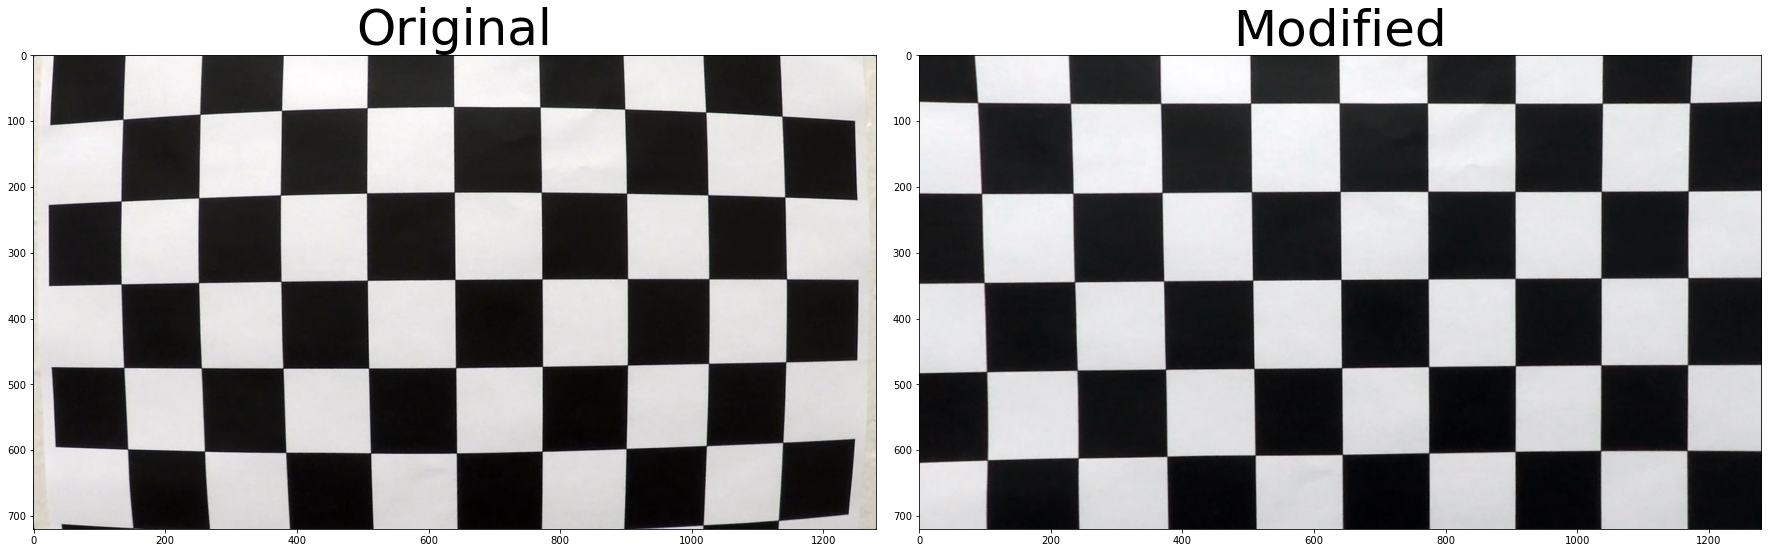

In [4]:
#Select example figure
example_image=cv2.imread('camera_cal/calibration1.jpg')
#Undistort figure
undistorted_example=cal.cal_undistort(example_image, obj_points, img_points)
#Plot and save for markup
visual.compare_images(example_image, undistorted_example, 1, 'output_images/writeup_chess_board', 'BGR', 'GRAY')

## 2- Pipeline (test images)

### 2.1 - Distortion correction

#### 2.1.1 - Apply to example images

In [5]:
for fname in glob.glob('test_images/*.jpg'):
    #Read image
    img=cv2.imread(fname)
    #Undistort image
    undistorted=cal.cal_undistort(img, obj_points, img_points)
    #Save images to output folder
    output_file_name='output_images/'+fname[12:-4]+'_undistorted.jpg'
    status = cv2.imwrite(output_file_name,undistorted)
    #Check if everything went well
    if not status:
        print('image not saved')

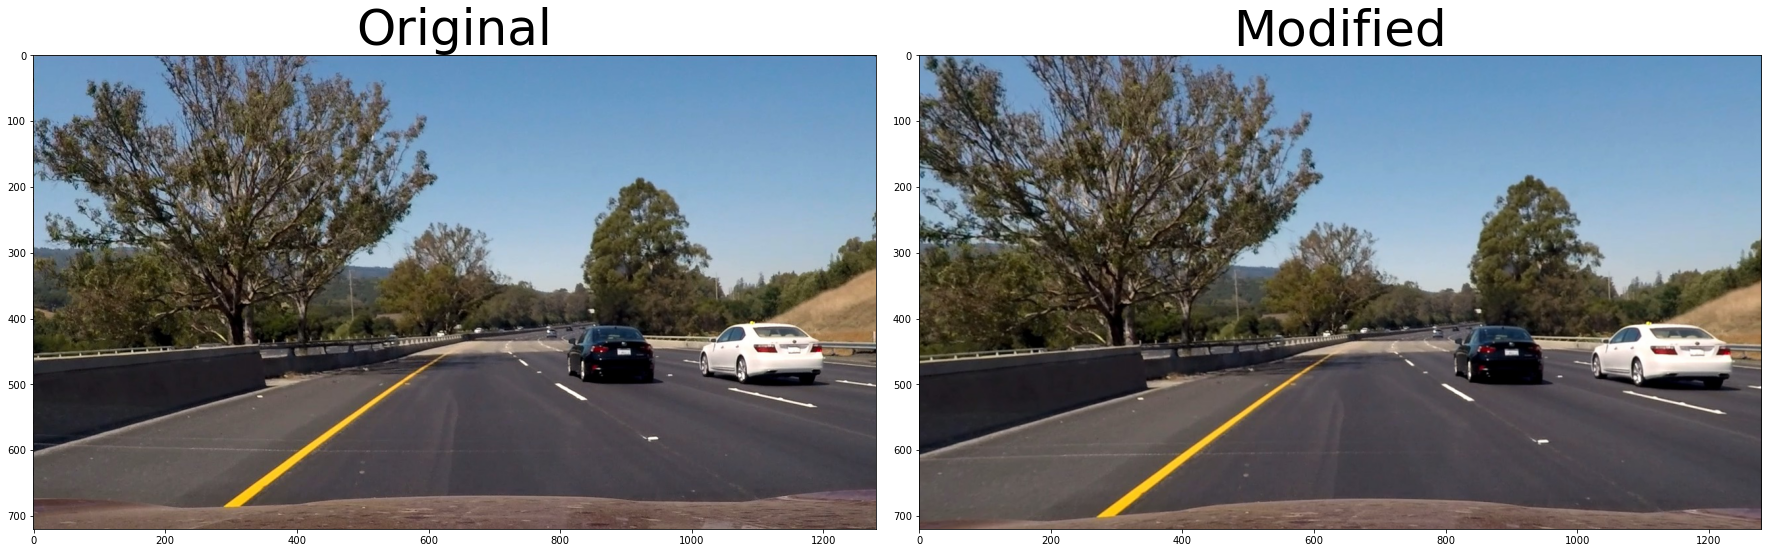

In [6]:
#Example image (last one) for writeup
visual.compare_images(img, undistorted, 1, 'output_images/writeup_distortion_correction', 'BGR', 'BGR')

### 2.2 - Create binary image

#### 2.2.1 - Import relevant libraries and functions

In [4]:
import binary_image_helper as binar

#### 2.2.2- Make function for pipeline

In [5]:
def binary_image(image):
    '''Isolates the lines very well, but have problems to find them in dark images'''
    image_HLS = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    S_channel=image_HLS[:,:,2]
    binary_S = binar.binary_threshold(S_channel, thresh=(150, 255))
    R_channel=image[:,:,0]
    binary_R = binar.binary_threshold(R_channel, thresh=(210, 255))
    combined = np.zeros_like(binary_R)
    combined[((binary_R == 1) & (binary_S == 1))] = 1
    return combined

def alt_binary_image(image):
    '''Finds the lines, but adding a lot of noise'''
    image_HLS = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    S_channel=image_HLS[:,:,2]
    binary_S = binar.binary_threshold(S_channel, thresh=(150, 255))
    R_channel=image[:,:,0]
    binary_R = binar.binary_threshold(R_channel, thresh=(210, 255))
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    dir_binary= binar.dir_sobel(gray, sobel_kernel=9, thresh=(0.8, 1.2))
    x_binary=binar.abs_sobel(gray, orient='x', sobel_kernel=9, thresh=(30, 150))
    combined = np.zeros_like(binary_R)
    combined[((binary_R == 1) & (binary_S == 1)) | ((x_binary == 1) & (dir_binary == 1))] = 1
    return combined

#### 2.2.3 - Apply to example images

In [9]:
for fname in glob.glob('output_images/*_undistorted.jpg'):
    #Read image
    image = mpimg.imread(fname)
    #Get binary image
    binary = alt_binary_image(image)
    #Save images to output folder
    output_file_name='output_images/'+fname[14:-16]+'_binary.jpg'
    plt.imsave(output_file_name, binary, cmap='gray')

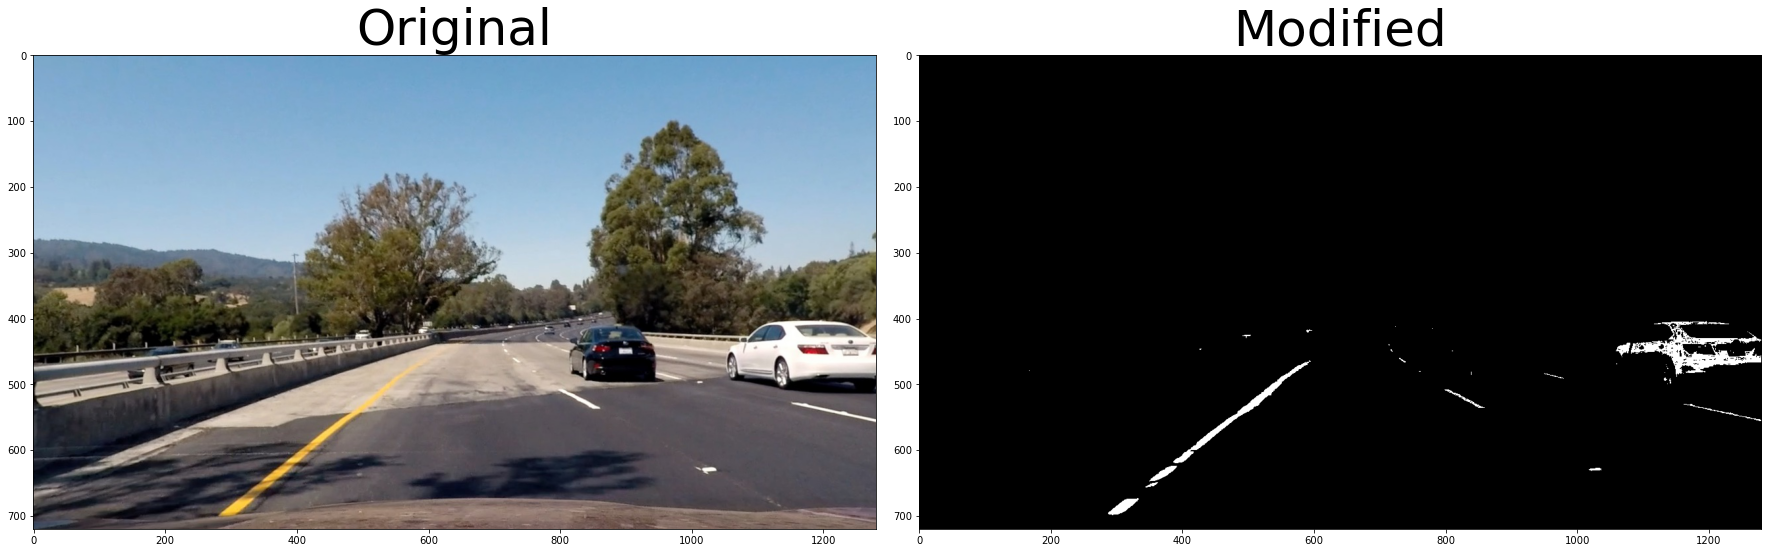

In [17]:
#Example image
image = mpimg.imread('output_images/test4_undistorted.jpg')
binary = binary_image(image)
visual.compare_images(image, binary, 1, 'output_images/writeup_binary_image', 'RGB', 'GRAY')

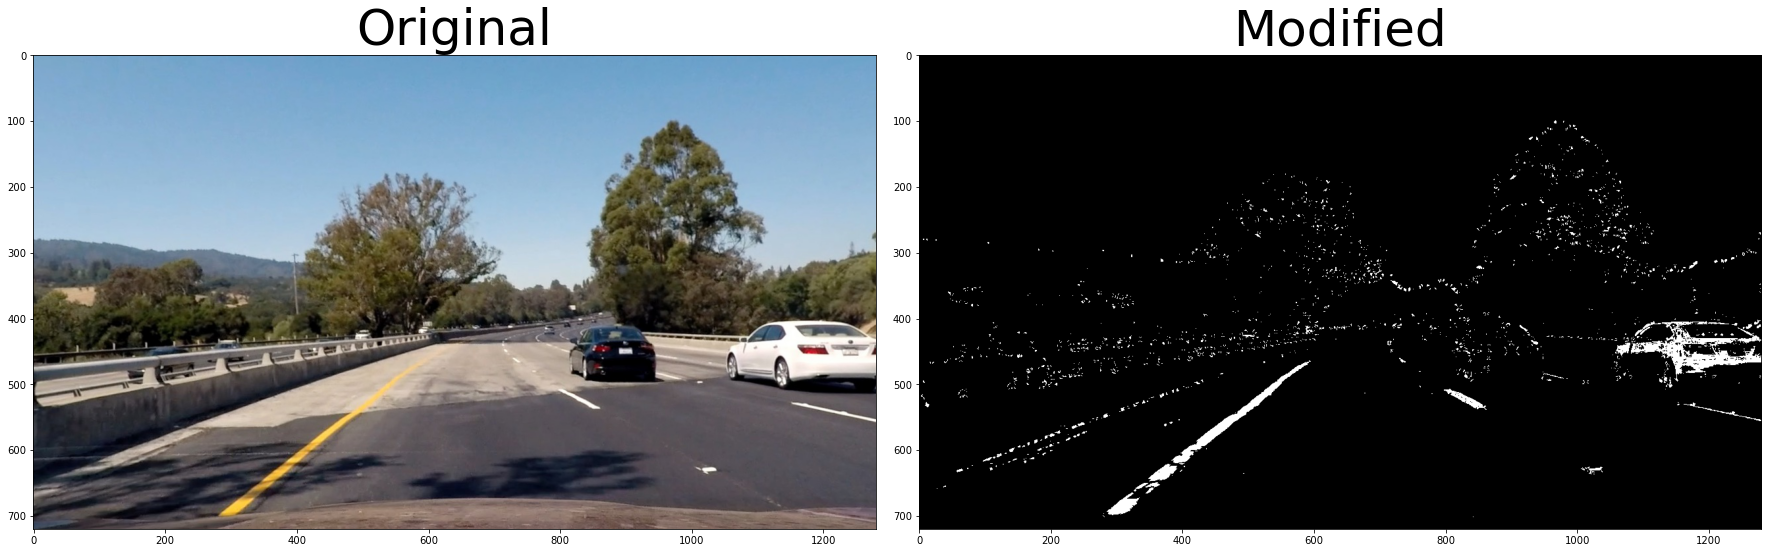

In [18]:
#Example image
image = mpimg.imread('output_images/test4_undistorted.jpg')
binary = alt_binary_image(image)
visual.compare_images(image, binary, 1, 'output_images/writeup_binary_image2', 'RGB', 'GRAY')

### 2.3- Perspective transform

#### 2.3.1 - Define relevant parameters

In [6]:
#This paramters define the position of the origin points to be used in the transform
x_offlow=450
x_offhigh=75

#### 2.3.2 - Apply to example images

In [12]:
for fname in glob.glob('output_images/*_binary.jpg'):
    #Read image
    image=cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
    #Get perspecive tranform
    transformed=cal.pers_transform(image, x_offlow, x_offhigh)
    #Save image to output folder
    output_file_name='output_images/'+fname[14:-11]+'_transformed.jpg'
    plt.imsave(output_file_name, transformed, cmap='gray')

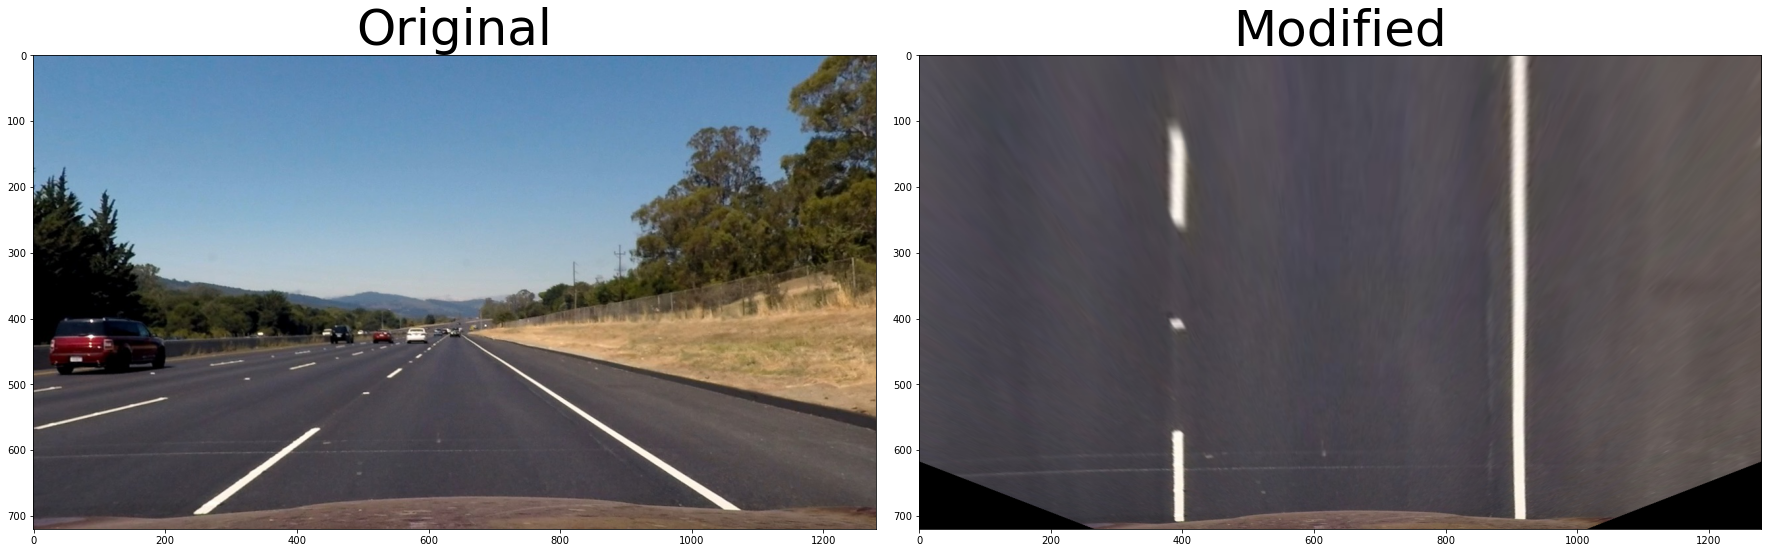

In [13]:
#Example image for writeup
image=cv2.imread('output_images/straight_lines2_undistorted.jpg')
transformed=cal.pers_transform(image, x_offlow, x_offhigh)
visual.compare_images(image, transformed, 1, 'output_images/writeup_transformed', 'BGR', 'BGR')

### 2.4- Finding lines (final pipeline)

#### 2.4.1 - Import relevant libraries and functions

In [7]:
import line_class as line

#### 2.4.2 - Create pipeline

In [8]:
def pipeline(image):
    #Undistort image
    undistorted = cal.cal_undistort(image, obj_points, img_points)
    #Create binary image
    binary = binary_image(undistorted)
    #Make perspective transform
    top_img = cal.pers_transform(binary, x_offlow, x_offhigh)
    #Split image vertically in 2
    midpoint = top_img.shape[1]//2
    left_top = top_img[:, :midpoint]
    right_top = top_img[:, midpoint:]
    #Update line parameters
    right_line.new_line(right_top)
    left_line.new_line(left_top)
    #Check if both lines exist
    if not left_line.exists:
        #Change binary image and try again
        binary_2 = alt_binary_image(undistorted)
        top_img_2 = cal.pers_transform(binary_2, x_offlow, x_offhigh)
        left_top = top_img_2[:, :midpoint]
        left_line.init_line(left_top)
        if not left_line.exists:
            # Use previous line
            left_line.retrieve_line(left_top)          
    if not right_line.exists:
        #Change binary image and try again
        binary_2 = alt_binary_image(undistorted)
        top_img_2 = cal.pers_transform(binary_2, x_offlow, x_offhigh)
        right_top = top_img_2[:, midpoint:]
        right_line.init_line(right_top)
        if not right_line.exists:
            # Use previous line
            right_line.retrieve_line(right_top)        
    ##Safety check on the two lines
    #Calculate lines distance
    midpoint_m = midpoint * xm_per_pix
    dist_top = (midpoint_m + right_line.dist[1] - left_line.dist[1])
    dist_bottom = (midpoint_m + right_line.dist[0] - left_line.dist[0])
    #Check lines 
    if check_curvature(right_line.avefit, left_line.avefit) or check_distance(dist_top, dist_bottom):
        #Reuse previous lines
        right_line.line_returned(right_top)
        left_line.line_returned(left_top)
    #Extract information
    left_fitx = left_line.poly
    right_fitx = right_line.poly + midpoint
    left_curverad = left_line.curverad
    right_curverad = right_line.curverad
    dist_center = (midpoint_m - left_line.dist[0] - right_line.dist[0])/2
    #Draw the lines and the data
    ploty = np.linspace(0, top_img.shape[0]-1, top_img.shape[0])
    result_image = visual.lanes_image(image, left_fitx, right_fitx, ploty, x_offlow, x_offhigh)
    visual.add_lane_par(result_image, left_curverad, right_curverad, dist_center)
    return result_image  

def check_curvature(polyfit_right, polyfit_left):
    wrong = False
    if (polyfit_right[0]*polyfit_left[0]) < 0:
        wrong = True
    return wrong

def check_distance(distance_top, distance_bottom):
    error_d = 1 #m
    wrong = False
    if distance_top < 0 or distance_bottom < 0 or np.abs(distance_top - distance_bottom) > error_d:
        wrong = True
    return wrong

#### 2.4.3 - Define relevant parameters and create lines

In [9]:
# Number of sliding windows
nwindows = 9
# Width of the windows +/- margin
margin = 100
# Minimum number of pixels found to recenter window
minpix = 50
# Meters per pixel in x and y direction
ym_per_pix = 3/160
xm_per_pix = 3.7/520

#### 2.4.4 - Apply to example images

In [21]:
for fname in glob.glob('test_images/*.jpg'):
    #Read image
    image = mpimg.imread(fname)
    #Initialize lines
    right_line = line.Line(nwindows, margin, minpix, xm_per_pix, ym_per_pix)
    left_line = line.Line(nwindows, margin, minpix, xm_per_pix, ym_per_pix)
    #Apply pipeline
    result = pipeline(image)
    #Save images to output folder
    output_file_name='output_images/'+fname[12:-4]+'_result.jpg'
    plt.imsave(output_file_name, result)

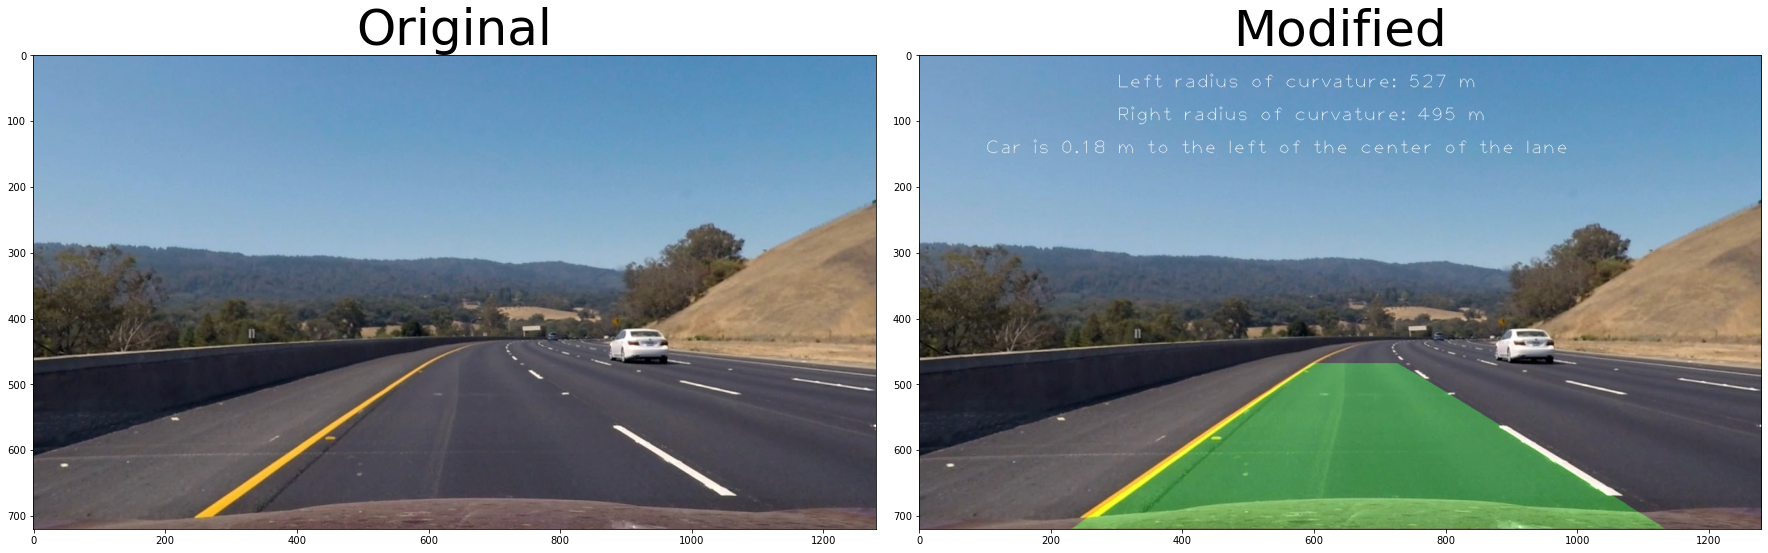

In [22]:
#Example for writeup
right_line = line.Line(nwindows, margin, minpix, xm_per_pix, ym_per_pix)
left_line = line.Line(nwindows, margin, minpix, xm_per_pix, ym_per_pix)
image=mpimg.imread('output_images/test3_undistorted.jpg')
result = pipeline(image)
visual.compare_images(image, result, 1, 'output_images/writeup_result_image', 'RGB', 'RGB')

## 3- Pipeline (video)

### 3.1 - Import relevant libraries and functions

In [13]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### 3.2 - Project video

#### 3.2.1 - Initialize line

In [19]:
right_line = line.Line(nwindows, margin, minpix, xm_per_pix, ym_per_pix)
left_line = line.Line(nwindows, margin, minpix, xm_per_pix, ym_per_pix)

#### 3.2.2 - Run video

In [20]:
white_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4



Moviepy - Done !
Moviepy - video ready project_video_output.mp4
Wall time: 24min 56s


### 3.3 - Challenge video

#### 3.3.1 - Initialize line

In [14]:
right_line = line.Line(nwindows, margin, minpix, xm_per_pix, ym_per_pix)
left_line = line.Line(nwindows, margin, minpix, xm_per_pix, ym_per_pix)

#### 3.3.2 - Run video

In [15]:
white_output = 'challenge_video_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 0/485 [00:00<?, ?it/s, now=None]

Moviepy - Building video challenge_video_output.mp4.
Moviepy - Writing video challenge_video_output.mp4



Moviepy - Done !
Moviepy - video ready challenge_video_output.mp4
Wall time: 11min 50s


### 3.4 - Harder challenge video

#### 3.4.1 - Initialize line

In [21]:
right_line = line.Line(nwindows, margin, minpix, xm_per_pix, ym_per_pix)
left_line = line.Line(nwindows, margin, minpix, xm_per_pix, ym_per_pix)

#### 3.4.2 - Run video

In [22]:
white_output = 'harder_challenge_video_output.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 0/1199 [00:00<?, ?it/s, now=None]

Moviepy - Building video harder_challenge_video_output.mp4.
Moviepy - Writing video harder_challenge_video_output.mp4



Moviepy - Done !
Moviepy - video ready harder_challenge_video_output.mp4
Wall time: 24min 20s
